# Propagation Evolution

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from PIL import Image

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms

# 防止内核挂掉
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
class Diffractive_Layer(torch.nn.Module):
    # 模型初始化（构造实例），默认实参波长为532e-9，网格总数50，网格大小20e-6，z方向传播0.002。
    def __init__(self, λ = 532e-9, N_pixels = 28*5, pixel_size = 20e-6, distance = 0.01):
        super(Diffractive_Layer, self).__init__() # 初始化父类
        
        # 以1/d为单位频率，得到一系列频率分量[0, 1, 2, ···, N_pixels/2-1,-N_pixels/2, ···, -1]/(N_pixels*d)。
        fx = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fy = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fxx, fyy = np.meshgrid(fx, fy) # 拉网格，每个网格坐标点为空间频率各分量。

        argument = (2 * np.pi)**2 * ((1. / λ) ** 2 - fxx ** 2 - fyy ** 2)

        # 计算传播场或倏逝场的模式kz，传播场kz为实数，倏逝场kz为复数
        tmp = np.sqrt(np.abs(argument))
        kz = torch.tensor(np.where(argument >= 0, tmp, 1j*tmp))
        self.phase = torch.exp(1j * kz * distance).to(device)

    def forward(self, E):
        # 定义单个衍射层内的前向传播
        E = E.to(device)
        fft_c = torch.fft.fft2(E) # 对电场E进行二维傅里叶变换
        c = torch.fft.fftshift(fft_c) # 将零频移至张量中心
        angular_spectrum = torch.fft.ifft2(torch.fft.ifftshift(c * self.phase)) # 卷积后逆变换得到响应的角谱
        return angular_spectrum

In [21]:
def propagation_along_z(initial_field, wl, N_pixels, pixel_size, z_step, number_of_z_steps):
    diffraction_step = Diffractive_Layer(distance = z_step, λ = wl, N_pixels = N_pixels, pixel_size = pixel_size)
    z_ind = np.arange(0, number_of_z_steps)
    full_cross_section =  torch.zeros((len(z_ind),N_pixels, N_pixels),dtype = torch.complex64)
    full_cross_section[0] = torch.tensor(initial_field)
    with torch.no_grad():
        for ind in z_ind[1:]:
            full_cross_section[ind] = diffraction_step(full_cross_section[ind-1])
            
        return full_cross_section

DISCRETIZATION_STEP = 1.0e-6 # 网格大小
N_pixels = 512 # xy平面边长的元素点数量
z_step = 1e-5 # z方向步长
number_of_z_steps = 500 # z方向步数
z = np.arange(0, number_of_z_steps)*z_step # z坐标
wl = 532e-9 # 波长
coord_limit = (N_pixels//2)*DISCRETIZATION_STEP # 建立xy坐标系
# 拉网格
mesh = np.arange(-coord_limit, coord_limit, DISCRETIZATION_STEP)
x, y = np.meshgrid(mesh, mesh)

In [22]:
# 高斯光束传输演化
BEAM_SIZE = 10e-6
beam = np.exp(-(x**2+y**2)/BEAM_SIZE**2)
field = propagation_along_z(beam, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)

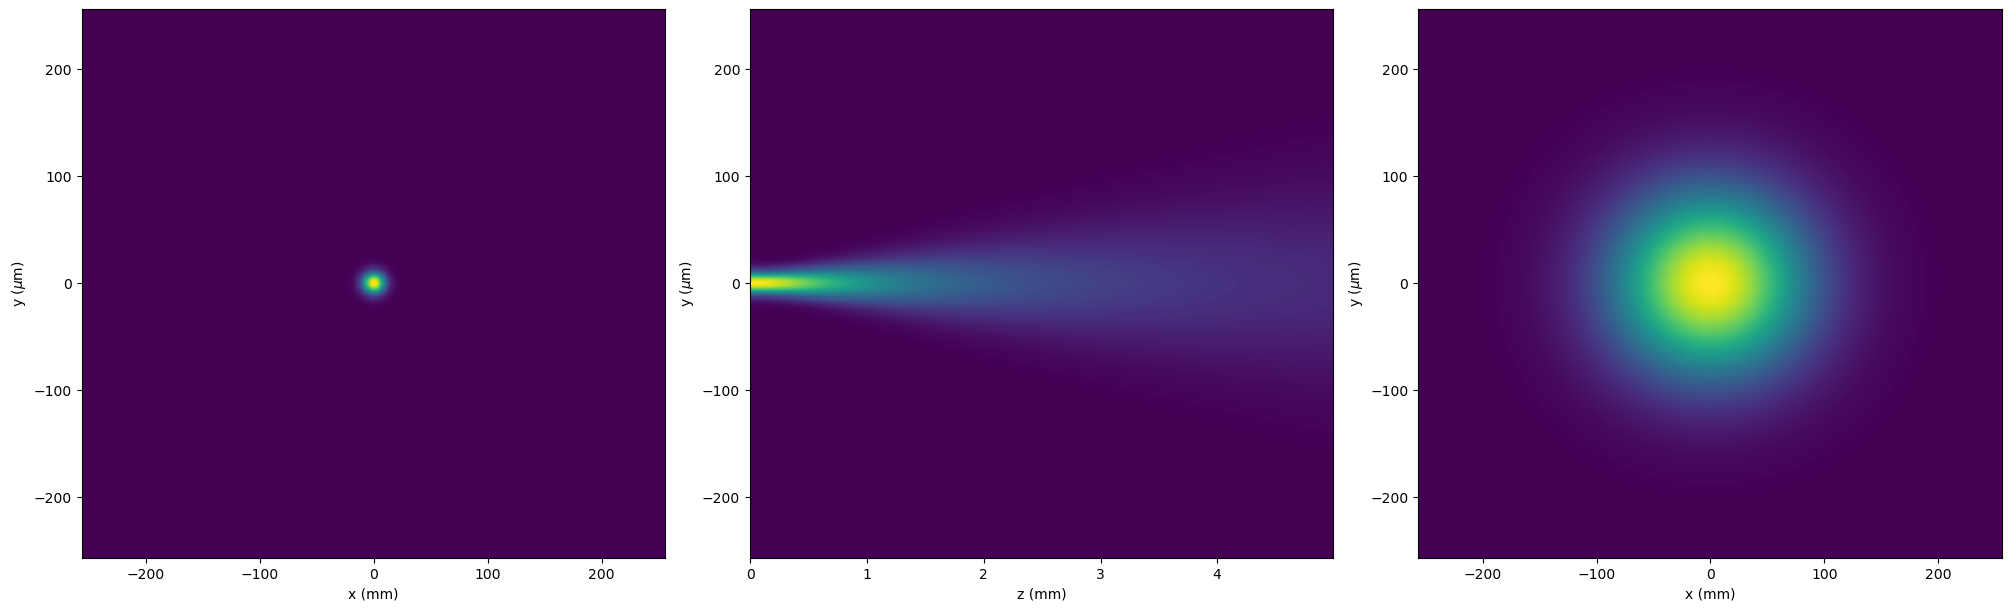

In [23]:
plt.rcParams["figure.figsize"] = (20, 6)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True)

# input
XY_field_in = np.abs(field[0].data.numpy())
ax1.pcolormesh(mesh*10**6, mesh*10**6, XY_field_in)
ax1.set_xlabel('x (mm)')
ax1.set_ylabel('y ($\mu$m)')

# yx cross-section
YZ_field = torch.abs(field[:, N_pixels//2])
ax2.pcolormesh(z*10**3, mesh*10**6, YZ_field.T)
ax2.set_xlabel('z (mm)')
ax2.set_ylabel('y ($\mu$m)')

# output
XY_field_out = torch.abs(field[-1]).T
ax3.pcolormesh(mesh*10**6, mesh*10**6, XY_field_out.T)
ax3.set_xlabel('x (mm)')
ax3.set_ylabel('y ($\mu$m)')

plt.show()

In [24]:
full_int = (torch.abs(field)**2).sum(dim=(1,2)) # 统计总光强
print(full_int)

tensor([157.0797, 157.0796, 157.0795, 157.0794, 157.0794, 157.0793, 157.0792,
        157.0791, 157.0791, 157.0790, 157.0789, 157.0789, 157.0788, 157.0787,
        157.0786, 157.0786, 157.0785, 157.0784, 157.0784, 157.0783, 157.0782,
        157.0782, 157.0781, 157.0780, 157.0780, 157.0779, 157.0778, 157.0777,
        157.0777, 157.0776, 157.0775, 157.0775, 157.0774, 157.0773, 157.0772,
        157.0772, 157.0771, 157.0770, 157.0770, 157.0769, 157.0768, 157.0768,
        157.0767, 157.0766, 157.0766, 157.0765, 157.0764, 157.0763, 157.0762,
        157.0762, 157.0761, 157.0760, 157.0760, 157.0759, 157.0758, 157.0758,
        157.0757, 157.0756, 157.0756, 157.0755, 157.0754, 157.0753, 157.0753,
        157.0752, 157.0751, 157.0751, 157.0750, 157.0749, 157.0749, 157.0748,
        157.0747, 157.0747, 157.0746, 157.0745, 157.0744, 157.0744, 157.0743,
        157.0743, 157.0742, 157.0741, 157.0740, 157.0740, 157.0739, 157.0738,
        157.0738, 157.0737, 157.0736, 157.0736, 157.0735, 157.07

In [29]:
BATCH_SIZE = 200
IMG_SIZE = 40
N_pixels = 140
PADDING = (N_pixels - IMG_SIZE) // 2  # 避免边缘信息丢失

# 数据预处理并加载
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((IMG_SIZE, IMG_SIZE))])
train_dataset = torchvision.datasets.MNIST("./data", train=True, transform=transform, download=True)
val_dataset = torchvision.datasets.MNIST("./data", train=False, transform=transform, download=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 定义一个绘图函数
def image_plot(image_E, label):
    norm = np.absolute(image_E.cpu().numpy())
    fig, ax = plt.subplots()
    ax.imshow(np.round(norm, 5)) # 显示图片每个像素点的振幅
    ax.axis('off')
    ax.set_title("E_norm & label={}".format(label))
#     fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax2)
    plt.show()

batch_number [100/300]
classes of the first batch: [0 1 2 3 4 5 6 7 8 9], number of classes: 10


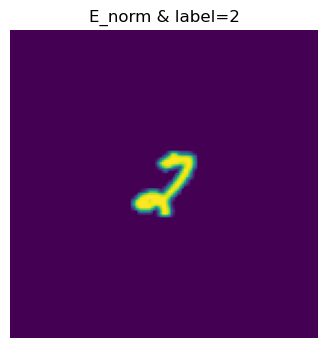

batch_number [200/300]
classes of the first batch: [0 1 2 3 4 5 6 7 8 9], number of classes: 10


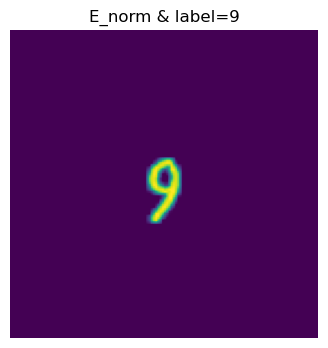

batch_number [300/300]
classes of the first batch: [0 1 2 3 4 5 6 7 8 9], number of classes: 10


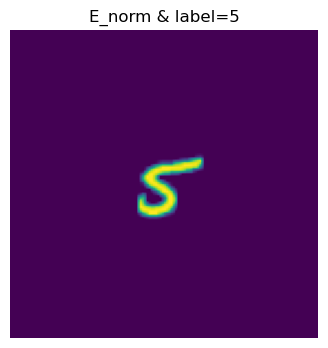

In [30]:
plt.rcParams["figure.figsize"] = (4, 4)
for i, (images, labels) in enumerate(train_dataloader):
    images = images.to(device)
    images_padded = F.pad(torch.squeeze(images), pad=(PADDING, PADDING, PADDING, PADDING))
    images_E = torch.sqrt(images_padded)
    labels = labels.to(device)
    if (i + 1) % 100 == 0:
        classes = torch.unique(labels).cpu().numpy()
        classes_num = len(classes)
        print('batch_number [{}/{}]'.format(i + 1, len(train_dataloader)))
        print('classes of the first batch: {}, number of classes: {}'.format(classes, classes_num))#  第一个batch的总类
        image_plot(images_E[0], labels[0])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2544\110149390.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_cross_section[0] = torch.tensor(initial_field)


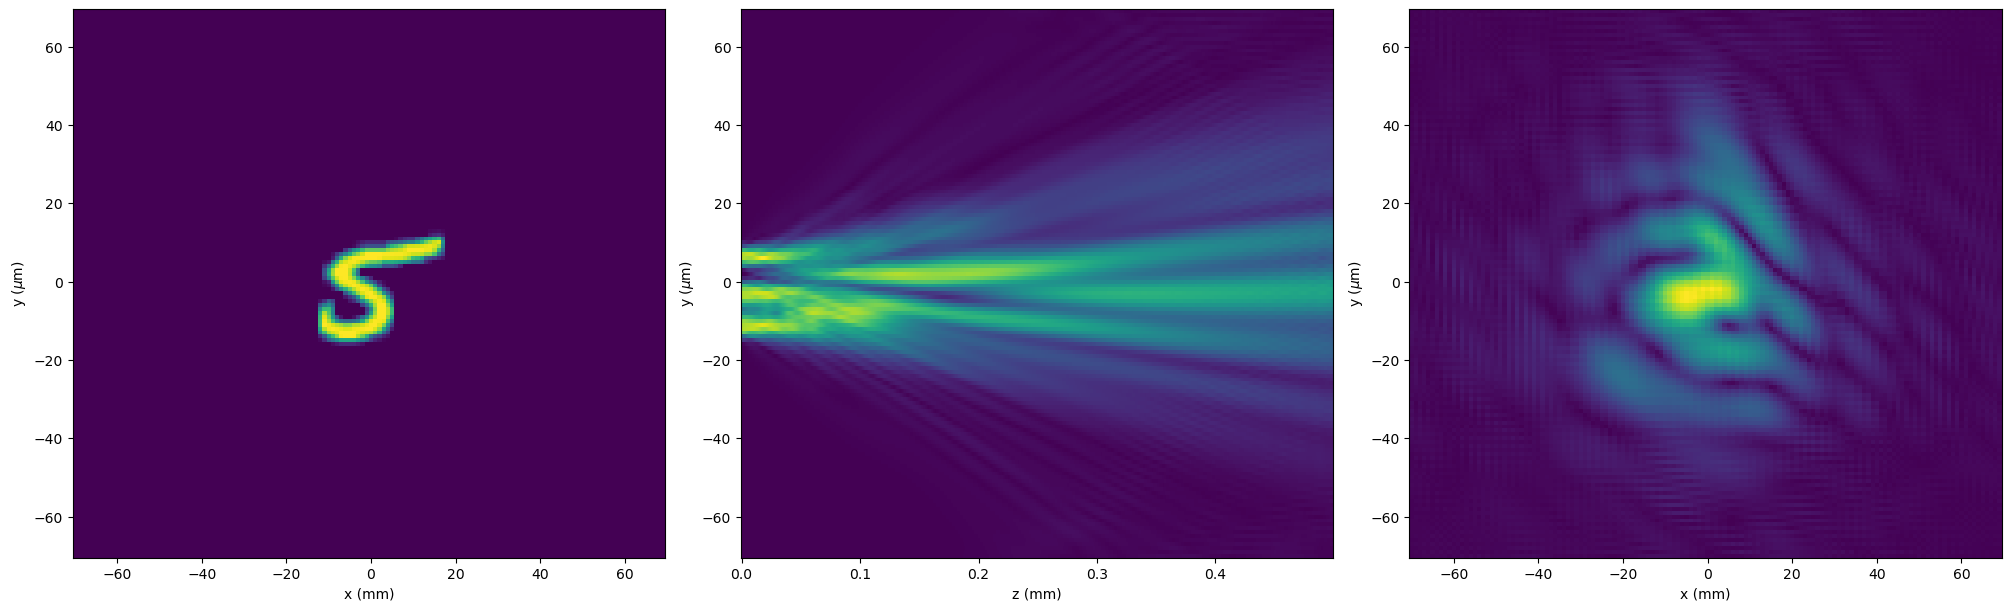

In [35]:
z_step = 1e-6 # z方向步长
number_of_z_steps = 500 # z方向步数

coord_limit = (N_pixels//2)*DISCRETIZATION_STEP # 建立xy坐标系
# 拉网格
mesh = np.arange(-coord_limit, coord_limit, DISCRETIZATION_STEP)

images_input = torch.flip(images_E[0], [0])
field = propagation_along_z(images_input, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)

plt.rcParams["figure.figsize"] = (20, 6)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True)

# input
XY_field_in = np.abs(field[0].data.numpy())
ax1.pcolormesh(mesh*10**6, mesh*10**6, XY_field_in)
ax1.set_xlabel('x (mm)')
ax1.set_ylabel('y ($\mu$m)')

# yz cross-section
YZ_field = torch.abs(field[:, :, N_pixels//2])
ax2.pcolormesh(z*10**2, mesh*10**6, YZ_field.T)
ax2.set_xlabel('z (mm)')
ax2.set_ylabel('y ($\mu$m)')

# output
XY_field_out = torch.abs(field[-1]).T
ax3.pcolormesh(mesh*10**6, mesh*10**6, XY_field_out.T)
ax3.set_xlabel('x (mm)')
ax3.set_ylabel('y ($\mu$m)')

plt.show()

In [36]:
full_int = (torch.abs(field)**2).sum(dim=(1,2)) # 统计总光强
print(full_int)

tensor([220.0799, 220.0799, 220.0800, 220.0800, 220.0800, 220.0800, 220.0800,
        220.0801, 220.0801, 220.0801, 220.0802, 220.0802, 220.0802, 220.0803,
        220.0803, 220.0803, 220.0803, 220.0804, 220.0804, 220.0804, 220.0805,
        220.0805, 220.0805, 220.0806, 220.0806, 220.0806, 220.0807, 220.0807,
        220.0807, 220.0807, 220.0808, 220.0808, 220.0808, 220.0808, 220.0809,
        220.0809, 220.0809, 220.0810, 220.0810, 220.0810, 220.0810, 220.0811,
        220.0811, 220.0811, 220.0812, 220.0812, 220.0812, 220.0812, 220.0813,
        220.0813, 220.0813, 220.0813, 220.0814, 220.0814, 220.0814, 220.0815,
        220.0815, 220.0815, 220.0816, 220.0816, 220.0816, 220.0816, 220.0816,
        220.0817, 220.0817, 220.0818, 220.0818, 220.0818, 220.0818, 220.0818,
        220.0819, 220.0819, 220.0819, 220.0820, 220.0820, 220.0820, 220.0821,
        220.0821, 220.0821, 220.0822, 220.0822, 220.0822, 220.0822, 220.0822,
        220.0822, 220.0823, 220.0823, 220.0824, 220.0824, 220.08